In [ ]:
!pip install openrouteservice

In [ ]:
import numpy as np
import pandas as pd
import openrouteservice
from openrouteservice import places
from shapely import wkt, geometry

We start by using `openrouteservice` to pull data on grocery stores from each Chicago neighborhood. This is a free API that anyone can make an account for.

In [ ]:
# Start by setting up the openrouteservice client
api_key = 'YOUR KEY'
client = openrouteservice.Client(key=api_key) # Specify your personal API key

# load the community areas from the csv file
chicago_data = pd.read_csv("CommAreas.csv")

# establish lists to store the names and details of grocery stores
names = []
coordinates = []
COMMUNITY = []
city = []

# Also store summary data for each community area
number = []
COMMUNITY_tots = []
city_tots = []
wkt_str_tots = []

# For each community area, get the grocery stores within it
for i in range(len(chicago_data['the_geom'])):
  wkt_str = str(chicago_data["the_geom"][i])
  aoi_geom = wkt.loads(wkt_str)  # load geometry from WKT string

  print("Looking at community ", chicago_data["COMMUNITY"][i])

  aoi_json = geometry.mapping(geometry.shape(aoi_geom))

  # The query is formatted to select green grocers, supermarkets and grocery stores
  query = {'request': 'pois',
        'geojson': aoi_json,
        'filter_category_ids': [474, 475, 518],
        'sortby': 'distance', }

  # Some areas have no grocery stores so we use a try excpet block to handle this
  try:
    grocery = client.places(**query)[0]['features']  # Perform the actual request and get inner json

    # Store summary data
    number.append(len(grocery))
    COMMUNITY_tots.append(chicago_data["COMMUNITY"][i])
    city_tots.append('Chicago')
    wkt_str_tots.append(wkt_str)

    # Store the details of each grocery store
    for g in grocery:
      try:
        names.append(g['properties']['osm_tags']['name'])
        coordinates.append(g['geometry']['coordinates']) #longitude, latitude
        city.append("Chicago")
        COMMUNITY.append(chicago_data["COMMUNITY"][i])
      except:
        continue
  except:
    number.append(0)
    COMMUNITY_tots.append(chicago_data["COMMUNITY"][i])
    city_tots.append('Chicago')
    wkt_str_tots.append(wkt_str)


# Save the summary data to a csv file
data_tots = {"city":city_tots, "wkt_str": wkt_str_tots, "COMMUNITY": COMMUNITY_tots, "number":number}
tots = pd.DataFrame(data_tots)
tots.to_csv("total_grocery.csv")

# Save the grocery store details to a csv file
data = {"city":city,  "COMMUNITY": COMMUNITY, "name":names, "coordinates": coordinates}
all = pd.DataFrame(data)
all.to_csv("all_grocery.csv")

I also have a `.shp` file which contains neighborhood information that is compatible with `ArcGIS` and can be used to create a map when uploaded to `ArcGIS online`. Here I simply add a column using `geopandas` that contains the cummulative statistics collected in the previous cell.

In [ ]:
import geopandas as gpd

#  Load the shp file downloaded from ArcGIS Online
shp_file = "geo_export_7c21eff6-5b92-4143-a3c5-4d61074010ad.shp"
shape = gpd.read_file(shp_file)

# Load the summary data from the previous section
new_data = pd.read_csv("total_grocery.csv")

# Add the number of grocery stores to the shape file and the community name to confirm the data is correct
shape["COMMUNITY"] = new_data["COMMUNITY"]
shape["number_of_grocery_stores"] = new_data["number"]
shape.to_file("geo_export_7c21eff6-5b92-4143-a3c5-4d61074010ad.shp")

In [14]:
# We can also take a look at the data to confirm it looks correct
shape.head()

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,number_of_grocery_stores,COMMUNITY
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((-87.60914 41.84469, -87.60915 41.844...",2,DOUGLAS
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((-87.59215 41.81693, -87.59231 41.816...",0,OAKLAND
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.62880 41.80189, -87.62879 41.801...",0,FULLER PARK
3,0.0,38,38,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816...",2,GRAND BOULEVARD
4,0.0,39,39,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((-87.59215 41.81693, -87.59215 41.816...",1,KENWOOD


In [1]:
import healpy as hp


In [14]:
imap = hp.read_map("/Users/mayamallaby-kay/Documents/Documents/Graduate_School/Research/anl/cutout_all_pixels_90_act_cib_map.fits")

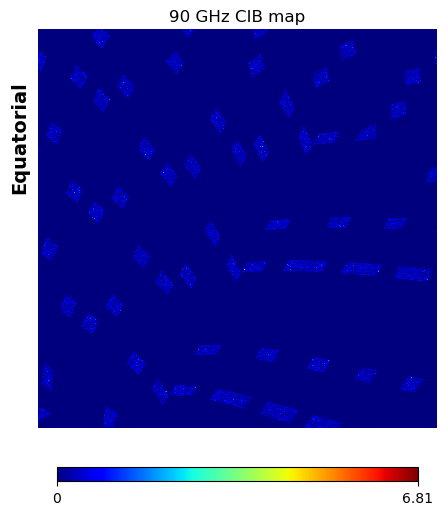

In [16]:
# plot a 5 degree by 5 degree region of the map
hp.cartview(imap, coord=['G','C'], lonra=[-25,25], latra=[-25,25], title='90 GHz CIB map', cmap='jet')

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

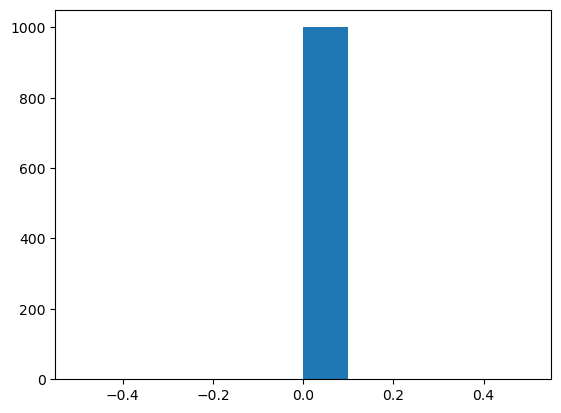

In [12]:
import matplotlib.pyplot as plt

plt.hist(imap[:1000])